In [1]:
# import libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import squarify
#Testing update 
#hello

In [2]:
#Load the data
data=pd.read_csv("sales_data.csv",encoding="unicode_escape", parse_dates=['order_date'])
data.head()

In [3]:
# setting the max rows and cols to display
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [4]:
#Glimpse of data
print(data.info())
print(data.head())
print(data.describe()) #validate min and max values of each values.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5009 entries, 0 to 5008
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   order_date   5009 non-null   datetime64[ns]
 1   order_id     5009 non-null   object        
 2   customer     5009 non-null   object        
 3   grand_total  5009 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 156.7+ KB
None
  order_date        order_id          customer  grand_total
0 2011-09-07  CA-2011-100006       Dennis Kane          378
1 2011-07-08  CA-2011-100090        Ed Braxton          699
2 2011-03-14  CA-2011-100293  Neil Franz?sisch           91
3 2011-01-29  CA-2011-100328   Jasper Cacioppo            4
4 2011-04-08  CA-2011-100363       Jim Mitchum           21
        grand_total
count   5009.000000
mean     458.626672
std      954.729307
min        1.000000
25%       38.000000
50%      152.000000
75%      512.000000
max 

In [5]:
max(data.order_date)

Timestamp('2014-12-31 00:00:00')

In [6]:
min(data.order_date)

Timestamp('2011-01-04 00:00:00')

In [7]:
#Calculating Recency
df_recency = data.groupby(by='customer',as_index=False)['order_date'].max()
df_recency.columns = ['CustomerName', 'LastPurchaseDate']
recent_date = df_recency['LastPurchaseDate'].max()
df_recency['Recency'] = df_recency['LastPurchaseDate'].apply(lambda x: (recent_date - x).days)
df_recency.head()

,CustomerName,LastPurchaseDate,Recency
0,Aaron Bergman,2013-11-11,415
1,Aaron Hawkins,2014-12-19,12
2,Aaron Smayling,2014-10-04,88
3,Adam Bellavance,2014-11-07,54
4,Adam Hart,2014-11-27,34


In [8]:
#Calculating Frequency
frequency_df = data.drop_duplicates().groupby(by=['customer'], as_index=False)['order_date'].count()
frequency_df.columns = ['CustomerName', 'Frequency']
frequency_df.head()

,CustomerName,Frequency
0,Aaron Bergman,3
1,Aaron Hawkins,7
2,Aaron Smayling,7
3,Adam Bellavance,8
4,Adam Hart,10


In [9]:
#Calculating Monetary value
monetary_df = data.groupby(by='customer', as_index=False)['grand_total'].sum()
monetary_df.columns = ['CustomerName', 'Monetary']
monetary_df.head()

,CustomerName,Monetary
0,Aaron Bergman,887
1,Aaron Hawkins,1744
2,Aaron Smayling,3050
3,Adam Bellavance,7756
4,Adam Hart,3249


In [10]:
#Merging
rf_df = df_recency.merge(frequency_df, on='CustomerName')
rfm_df = rf_df.merge(monetary_df, on='CustomerName').drop(columns='LastPurchaseDate')
rfm_df.head()

,CustomerName,Recency,Frequency,Monetary
0,Aaron Bergman,415,3,887
1,Aaron Hawkins,12,7,1744
2,Aaron Smayling,88,7,3050
3,Adam Bellavance,54,8,7756
4,Adam Hart,34,10,3249


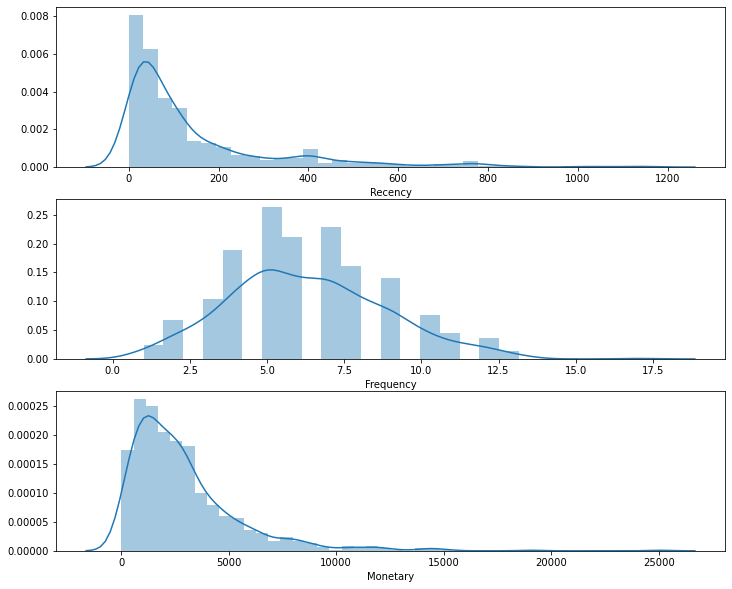

In [11]:
# Plot RFM distributions
plt.figure(figsize=(12,10))
# Plot distribution of R
plt.subplot(3, 1, 1); sns.distplot(rfm_df['Recency'])
# Plot distribution of F
plt.subplot(3, 1, 2); sns.distplot(rfm_df['Frequency'])
# Plot distribution of M
plt.subplot(3, 1, 3); sns.distplot(rfm_df['Monetary'])
# Show the plot
plt.show()

In [19]:
# --Calculate R and F groups--
# Create labels for Recency, Frequency and MonetaryValue
r_labels = range(4, 0, -1)
f_labels = range(1, 5)
m_labels = range(1, 5)
# Create new column M
# Assign these labels to 4 equal percentile groups 
r_groups = pd.qcut(rfm_df['Recency'], q=4, labels=r_labels)
# Assign these labels to 4 equal percentile groups 
f_groups = pd.qcut(rfm_df['Frequency'], q=4, labels=f_labels)
# Assign these labels to three equal percentile groups 
m_groups = pd.qcut(rfm_df['Monetary'], q=4, labels=m_labels)

#pd.qcut(s,len(s.dropna()),duplicates='drop')
# Create new columns R, F and M
rfm_df = rfm_df.assign(R = r_groups.values, F=f_groups.values, M=m_groups.values)
rfm_df.head()

,CustomerName,Recency,Frequency,Monetary,R,F,M
0,Aaron Bergman,415,3,887,1,1,1
1,Aaron Hawkins,12,7,1744,4,3,2
2,Aaron Smayling,88,7,3050,2,3,3
3,Adam Bellavance,54,8,7756,3,3,4
4,Adam Hart,34,10,3249,3,4,3


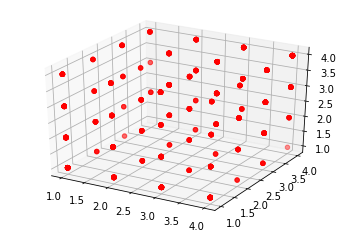

In [20]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(rfm_df['R'],rfm_df['F'],rfm_df['M'],color="red",label="RFM")

In [21]:
rfm_df.head()

,CustomerName,Recency,Frequency,Monetary,R,F,M
0,Aaron Bergman,415,3,887,1,1,1
1,Aaron Hawkins,12,7,1744,4,3,2
2,Aaron Smayling,88,7,3050,2,3,3
3,Adam Bellavance,54,8,7756,3,3,4
4,Adam Hart,34,10,3249,3,4,3


In [22]:
# Concat RFM quartile values to create RFM Segments
def join_rfm(x): return str(x['R']) + str(x['F']) + str(x['M'])
rfm_df['RFM_Segment_Concat'] = rfm_df.apply(join_rfm, axis=1)
rfm = rfm_df
rfm.head()

,CustomerName,Recency,Frequency,Monetary,R,F,M,RFM_Segment_Concat
0,Aaron Bergman,415,3,887,1,1,1,111
1,Aaron Hawkins,12,7,1744,4,3,2,432
2,Aaron Smayling,88,7,3050,2,3,3,233
3,Adam Bellavance,54,8,7756,3,3,4,334
4,Adam Hart,34,10,3249,3,4,3,343


In [23]:
# Calculate RFM_Score
rfm['RFM_Score'] = rfm[['R','F','M']].sum(axis=1)
print(rfm['RFM_Score'].head())

0     3.0
1     9.0
2     8.0
3    10.0
4    10.0
Name: RFM_Score, dtype: float64


In [24]:
# Define rfm_level function
def rfm_level(df):
    if df['RFM_Score'] >= 9:
        return 'Can\'t Loose Them'
    elif ((df['RFM_Score'] >= 8) and (df['RFM_Score'] < 9)):
        return 'Champions'
    elif ((df['RFM_Score'] >= 7) and (df['RFM_Score'] < 8)):
        return 'Loyal'
    elif ((df['RFM_Score'] >= 6) and (df['RFM_Score'] < 7)):
        return 'Potential'
    elif ((df['RFM_Score'] >= 5) and (df['RFM_Score'] < 6)):
        return 'Promising'
    elif ((df['RFM_Score'] >= 4) and (df['RFM_Score'] < 5)):
        return 'Needs Attention'
    else:
        return 'Require Activation'
# Create a new variable RFM_Level
rfm['RFM_Level'] = rfm.apply(rfm_level, axis=1)
# Print the header with top 5 rows to the console
rfm.head()

,CustomerName,Recency,Frequency,Monetary,R,F,M,RFM_Segment_Concat,RFM_Score,RFM_Level
0,Aaron Bergman,415,3,887,1,1,1,111,3.0,Require Activation
1,Aaron Hawkins,12,7,1744,4,3,2,432,9.0,Can't Loose Them
2,Aaron Smayling,88,7,3050,2,3,3,233,8.0,Champions
3,Adam Bellavance,54,8,7756,3,3,4,334,10.0,Can't Loose Them
4,Adam Hart,34,10,3249,3,4,3,343,10.0,Can't Loose Them


In [25]:
# Calculate average values for each RFM_Level, and return a size of each segment 
rfm_level_agg = rfm.groupby('RFM_Level').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
}).round(1)
# Print the aggregated dataset
print(rfm_level_agg)

                   Recency Frequency Monetary      
                      mean      mean     mean count
RFM_Level                                          
Can't Loose Them      55.1       8.6   4510.3   289
Champions             79.7       6.6   3381.5    92
Loyal                132.0       6.3   2756.2    77
Needs Attention      298.3       3.9   1145.5    72
Potential            116.8       4.8   2070.1   103
Promising            200.0       4.6   1483.6    93
Require Activation   461.0       3.2    549.0    67


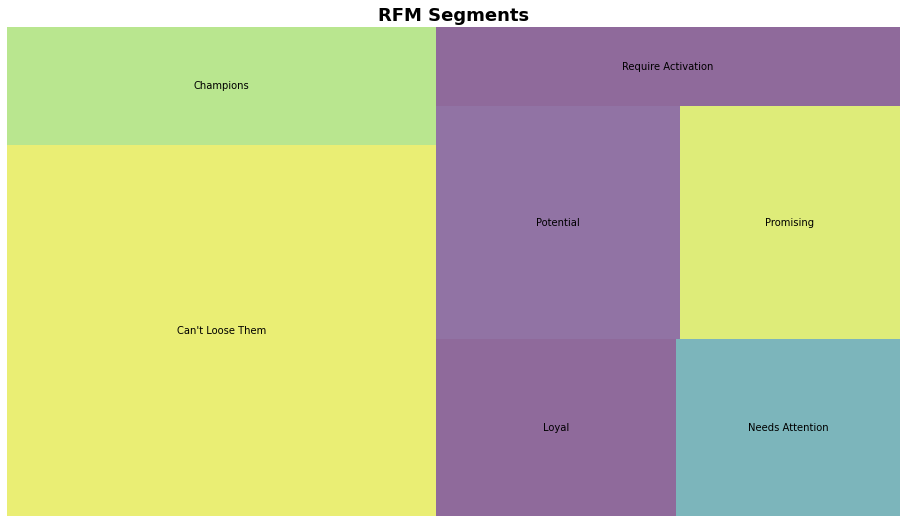

In [26]:
rfm_level_agg.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count']
#Create our plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 9)
squarify.plot(sizes=rfm_level_agg['Count'], 
              label=['Can\'t Loose Them',
                     'Champions',
                     'Loyal',
                     'Needs Attention',
                     'Potential', 
                     'Promising', 
                     'Require Activation'], alpha=.6 )
plt.title("RFM Segments",fontsize=18,fontweight="bold")
plt.axis('off')
plt.show()

In [ ]:
rfm.to_csv("rfmdata.csv")

In [28]:
#Promising - Faithful customers
#RFM Score: X41, X42
promising=rfm.loc[(rfm['F'] == 4) & (rfm['M'] <= 2)]
print(promising["CustomerName"])

16     Alejandro Ballentine
24             Allen Armold
118             Bryan Mills
163           Cindy Chapman
182             Cyma Kinney
198           Darren Powers
227            Denny Ordway
298            Gene McClure
300             George Bell
308            Greg Guthrie
313           Guy Armstrong
358        Jennifer Braxton
364            Jeremy Farry
407          Julie Prescott
419              Karl Braun
475        Logan Haushalter
485         Maria Bertelson
497           Mark Van Huff
524        Michael Granlund
538           Mick Crebagga
550      Muhammed MacIntyre
566            Neoma Murray
575               Nona Balk
579           Odella Nelson
591           Paul Gonzalez
646             Roger Demir
691          Shahid Hopkins
708        Stephanie Phelps
731           Tamara Dahlen
762            Tony Chapman
Name: CustomerName, dtype: object


In [29]:
#Whales - Your Highest Paying Customers
#RFM Score: XX4
whales=rfm.loc[rfm['M'] == 4]
print(whales["CustomerName"])

3           Adam Bellavance
6             Adrian Barton
11           Alan Dominguez
13               Alan Hwang
14        Alan Schoenberger
20               Alex Avila
29                  Amy Cox
35              Andy Reiter
42            Anna Andreadi
45            Anna H?berlin
46           Anne McFarland
48            Annie Thurman
51           Anthony Jacobs
52          Anthony Johnson
54           Anthony Rawles
56           Arianne Irving
59            Arthur Gainer
73             Bart Watters
75             Becky Martin
77               Ben Ferrer
87           Bill Donatelli
88              Bill Eplett
90             Bill Shonely
91             Bill Stewart
99          Bradley Drucker
102           Brenda Bowman
109              Brian Moss
113         Brosina Hoffman
129             Carol Adams
132         Caroline Jumper
133       Cassandra Brandow
137          Cathy Prescott
146            Chris Cortes
154          Christine Phan
156      Christopher Conant
157    Christopher M

In [31]:
#Loyal - Your Most Loyal Customers
#RFM Score: X4X
loyal=rfm.loc[rfm_df['F'] == 4]
print(loyal["CustomerName"])

4                 Adam Hart
5        Adam Shillingsburg
6             Adrian Barton
13               Alan Hwang
16     Alejandro Ballentine
24             Allen Armold
45            Anna H?berlin
48            Annie Thurman
56           Arianne Irving
59            Arthur Gainer
60           Arthur Prichep
72             Bart Pistole
74            Becky Castell
77               Ben Ferrer
78             Ben Peterman
87           Bill Donatelli
102           Brenda Bowman
109              Brian Moss
118             Bryan Mills
128          Carlos Soltero
133       Cassandra Brandow
145     Chloris Kastensmidt
146            Chris Cortes
148         Chris Selesnick
149      Christina Anderson
155    Christine Sundaresam
158      Christopher Schild
160             Chuck Clark
163           Cindy Chapman
169             Clay Ludtke
171            Clytie Kelty
182             Cyma Kinney
185           Cynthia Voltz
187         Damala Kotsonis
188            Dan Campbell
190         Dan Reic

In [33]:
#Core - Your Best Customers
#RFM Score: 444
core=rfm.loc[(rfm['R']==4) & (rfm['F'] == 4) & (rfm['M'] == 4)]
print(core["CustomerName"])

13            Alan Hwang
48         Annie Thurman
56        Arianne Irving
77            Ben Ferrer
102        Brenda Bowman
146         Chris Cortes
190      Dan Reichenbach
213            Dean Katz
259           Emily Phan
270           Erin Smith
296        Gary Zandusky
322          Harry Marie
342         James Galang
387             John Lee
457       Lena Creighton
526        Michael Moore
539       Mick Hernandez
543       Mike Pelletier
556    Natalie DeCherney
588      Patrick O'Brill
603            Pete Kriz
615         Quincy Jones
629         Rick Bensley
659    Russell Applegate
672         Sanjit Engle
690     Shahid Collister
728       Suzanne McNair
740     Theone Pippenger
782      Victoria Wilson
787        William Brown
Name: CustomerName, dtype: object
